In [7]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import os

In [11]:
class CustomImageDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file, index_col = 0)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.landmarks_frame.iloc[idx, 0]
        image = cv2.imread(img_name)
        # image = image.view((224,224,3))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # # image = np.transpose(image,(1,2,0)) 
        label = self.landmarks_frame.iloc[idx, 1]
        label = np.array(label)
        if self.transform:
            image = self.transform(image)
        return image,label

In [12]:
from facenet_pytorch import fixed_image_standardization, training
preprocessing = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    transforms.Resize((160,160)),
    fixed_image_standardization
])

trainset = CustomImageDataset(csv_file = 'mask_train.csv',
                              root_dir='train/',
                             transform = preprocessing)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 160, 160])
1 torch.Size([3, 160, 160])
2 torch.Size([3, 160, 160])
3 torch.Size([3, 160, 160])


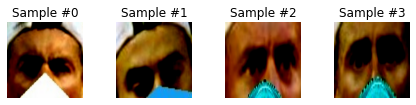

In [13]:
for i in range(len(trainset)):
    data,label = trainset[i+3]

    print(i, data.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(data.permute(1,2,0))
    if i == 3:
        plt.show()
        break

In [14]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=8,
                        shuffle=True, num_workers=0)

In [15]:
testset = CustomImageDataset(csv_file = 'mask_test.csv',
                              root_dir='test/',
                             transform = preprocessing)
testloader = DataLoader(testset, batch_size=8,
                        shuffle=True, num_workers=0)
valset = CustomImageDataset(csv_file = 'mask_val.csv',
                              root_dir='val/',
                             transform = preprocessing)
valloader = DataLoader(valset, batch_size=8,
                        shuffle=True, num_workers=0)

In [8]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import InceptionResnetV1
from torch import optim
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes= 51
).eval().to(device)
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [17]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
epochs = 70
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, valloader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, trainloader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, valloader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    20/20   | loss:    4.0507 | fps:   99.5208 | acc:    0.0125   

Epoch 1/70
----------
Train |   153/153  | loss:    4.1076 | fps:   75.1397 | acc:    0.0515   
Valid |    20/20   | loss:    4.0668 | fps:  111.0533 | acc:    0.0750   

Epoch 2/70
----------
Train |   153/153  | loss:    3.8904 | fps:   76.8487 | acc:    0.0757   
Valid |    20/20   | loss:    5.1502 | fps:  145.5469 | acc:    0.0729   

Epoch 3/70
----------
Train |   153/153  | loss:    3.7740 | fps:   77.6565 | acc:    0.0956   
Valid |    20/20   | loss:    3.6002 | fps:  113.9749 | acc:    0.1125   

Epoch 4/70
----------
Train |   153/153  | loss:    3.7066 | fps:   78.8175 | acc:    0.0948   
Valid |    20/20   | loss:    3.5539 | fps:  122.2869 | acc:    0.1312   

Epoch 5/70
----------
Train |   153/153  | loss:    3.5648 | fps:   77.0100 | acc:    0.1234   
Valid |    20/20   | loss:    5.3359 | fps:  129.8016 | acc:    0.1229   

Epoch 6/70
----------
Train |   153/153  | loss: 

In [18]:
torch.save(resnet.state_dict(),'model_parameter.pth')

In [19]:
resnet.load_state_dict(torch.load('model_parameter.pth'), strict=False)
correct = 0
total = 0
sample_count = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         print(labels)
        # calculate outputs by running images through the network
        outputs = resnet(images)
        # the class with the highest energy is what we choose as prediction
        _,predicted  = torch.max(outputs, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # if 0 in (predicted == labels):
        #     determinant = predicted == labels
        #     for j in range(len(determinant)):
        #         if determinant[j] == False:
        #             print(f'False Sample {sample_count+1}: True Labels: {labels[j].item()}, Predicted:{predicted[j].item()}')
        #             plt.imshow(images[j].cpu().permute(1,2,0))

print(f'Accuracy of the network on the 182 test images: {100 * correct // total} %')

Accuracy of the network on the 182 test images: 41 %
